<a href="https://colab.research.google.com/github/Pbonmars-20031006/Assignment-1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyqtree
!pip install Rtree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import timeit
import random
from pyqtree import Index
from rtree import index as rtree_index  # Use an alias for the imported module
from rtree import index

  Preparing metadata (setup.py) ... done
  Created wheel for pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5968 sha256=997d1ccdef18933bf6df305b19100e7985f8c18072588f8c6d48e096093bf0cd
  Stored in directory: /root/.cache/pip/wheels/63/e6/90/6e15bfb4299fd41f88a9affca879f44bde40d3dc6f398462a8
Successfully built pyqtree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 6.6 MB/s eta 0:00:00


In [ ]:
# a class named rectdetails to store all the details of a given rectangle, helping in easy of access
class RectDetails:
    def __init__(self , rectangle_id, left_bottom_x, left_bottom_y, right_top_x, right_top_y):
        self.rectangle_id = rectangle_id  # stores the id of the rectangle
        self.left_bottom_corner_x = left_bottom_x  #stores the left bottom x coordinate
        self.left_bottom_corner_y = left_bottom_y  #stores the left bottom y coordinate
        self.right_top_corner_x = right_top_x #stores the right bottom x coordinate
        self.right_top_corner_y = right_top_y #stores the right bottom x coordinate


Saving randomset.txt to randomset (1).txt


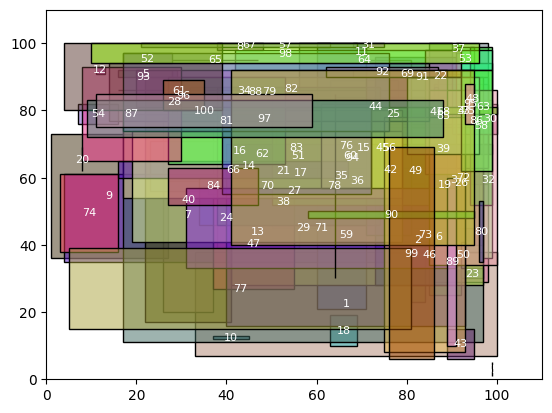

Enter x coordinate: 25
Enter y coordinate: 30
Naive
73 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
RTree
26.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
The point (25.0, 30.0) is enclosed in the rectangles: [29, 40, 77]
The point (25.0, 30.0) is enclosed in the rectangles: [29, 40, 77]
Non-overlapping rectangles: [55]
2.52 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
Overlapping rectangles: {1: [2, 7, 10, 18, 19, 23, 24, 26, 29, 32, 35, 36, 40, 43, 46, 47, 49, 50, 59, 71, 72, 73, 77, 78, 80, 89, 99], 2: [1, 6, 25, 29, 36, 42, 49, 59, 60, 71, 73, 90, 94, 99], 3: [4, 6, 19, 25, 26, 29, 33, 36, 39, 41, 42, 44, 45, 48, 49, 50, 58, 59, 68, 71, 72, 73, 75, 85, 86, 89, 90, 94, 95, 97, 99], 4: [3, 25, 26, 29, 33, 36, 39, 44, 45, 48, 53, 59, 64, 72, 73, 75, 85, 94], 5: [79, 82, 87, 88, 93], 6: [2, 3, 19, 26, 29, 36, 42, 49, 50, 56, 59, 70, 71, 72, 73, 80, 89, 94, 99], 7: [1, 9, 14, 16, 24, 27, 28, 29, 38, 40, 62, 66, 70, 71, 77, 79, 8

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io

def plot_rect(ax, position, size, rectangle_id):
    edge_color = 'black'
    face_color = (random.random(), random.random(), random.random(), 0.5)
    rectangle = patches.Rectangle(position, size[0], size[1], edgecolor=edge_color, facecolor=face_color,)
    ax.add_patch(rectangle)

    # Display rectangle ID as a label inside the rectangle
    ax.text(position[0] + size[0] / 2, position[1] + size[1] / 2, str(rectangle_id),
            color='white', ha='center', va='center', fontsize=8)

def read_rectangles_from_file(file_content):
    rectangles = []
    for line in file_content:
        try:
            data = list(map(int, line.strip('{}\n, ').split(',')))
            rectangles.append(data)
        except ValueError:
            pass
    return rectangles

def batch_insert_rtree(idx, rectangles):
    for rect_params in rectangles:
        rect_instance = RectDetails(*rect_params)
        bbox = (rect_instance.left_bottom_corner_x, rect_instance.left_bottom_corner_y,
                rect_instance.right_top_corner_x, rect_instance.right_top_corner_y)
        idx.insert(rect_instance.rectangle_id, bbox)

def find_enclosing_rectangles_rtree(point, rtree_idx):
    enclosing_rectangles = []
    x, y = point

    for rect_id in rtree_idx.intersection((x, y, x, y)):
        enclosing_rectangles.append(rect_id)

    return enclosing_rectangles


def non_overlapping_rectangles_naive(rectangles):
    non_overlapping = []
    for i, rect1 in enumerate(rectangles):
        is_overlapping = False
        for j, rect2 in enumerate(rectangles):
            if i != j and (rect1[1] < rect2[3] and rect1[3] > rect2[1] and rect1[2] < rect2[4] and rect1[4] > rect2[2]):
                is_overlapping = True
                break
        if not is_overlapping:
            non_overlapping.append(rect1[0])

    return non_overlapping

def is_point_inside_rect(point, rect_instance):
    x, y = point
    return (
        rect_instance.left_bottom_corner_x <= x <= rect_instance.right_top_corner_x and
        rect_instance.left_bottom_corner_y <= y <= rect_instance.right_top_corner_y
    )

def find_enclosing_rectangles(point, rectangles):
    enclosing_rectangles = []

    for index, set_of_numbers in enumerate(rectangles, start=1):
        rect_instance = RectDetails(*set_of_numbers)
        if is_point_inside_rect(point, rect_instance):
            enclosing_rectangles.append(index)

    return enclosing_rectangles

def find_overlapping_rectangles(rectangles):
    overlapping_rectangles = {}

    for i, rect1 in enumerate(rectangles):
        overlapping_rectangles[i + 1] = []
        for j, rect2 in enumerate(rectangles):
            if i != j and (rect1[1] < rect2[3] and rect1[3] > rect2[1] and rect1[2] < rect2[4] and rect1[4] > rect2[2]):
                overlapping_rectangles[i + 1].append(j + 1)

    return overlapping_rectangles

def find_overlapping_rectangles_rtree(rectangles, rtree_idx):
    overlapping_rectangles = {}

    for i, rect_params in enumerate(rectangles):
        rect_instance = RectDetails(*rect_params)
        bbox = (rect_instance.left_bottom_corner_x, rect_instance.left_bottom_corner_y,
                rect_instance.right_top_corner_x, rect_instance.right_top_corner_y)

        # Find rectangles overlapping with the current rectangle using R-tree
        overlapping = list(rtree_idx.intersection(bbox))
        overlapping.remove(rect_instance.rectangle_id)  # Remove self from overlapping list

        # Check for true overlap (not just touching at edges)
        true_overlapping = [r for r in overlapping if not (
            rect_instance.left_bottom_corner_x >= rectangles[r-1][3] or
            rect_instance.right_top_corner_x <= rectangles[r-1][1] or
            rect_instance.left_bottom_corner_y >= rectangles[r-1][4] or
            rect_instance.right_top_corner_y <= rectangles[r-1][2]
        )]

        overlapping_rectangles[rect_instance.rectangle_id] = true_overlapping

    return overlapping_rectangles


def main():
    # Upload your_file.txt
    uploaded = files.upload()

    # Get the name of the uploaded file
    file_name = list(uploaded.keys())[0]

    # Create a file-like object from the uploaded content
    file_content = uploaded[file_name].decode('utf-8')
    rectangles = read_rectangles_from_file(io.StringIO(file_content))

    # Extract maximum x and y values from the dataset
    max_x = max(rect[3] for rect in rectangles)  # Maximum right_top_corner_x
    max_y = max(rect[4] for rect in rectangles)  # Maximum right_top_corner_y

    # Create an R-tree index
    p = rtree_index.Property()
    rtree_idx = rtree_index.Index(properties=p)

    # Batch insert into R-tree
    batch_size = 2000  # Adjust the batch size based on your available memory
    for i in range(0, len(rectangles), batch_size):
        batch = rectangles[i:i+batch_size]
        batch_insert_rtree(rtree_idx, batch)

    # Plot the rectangles
    fig, ax = plt.subplots()
    ax.set_xlim(0, max_x + (0.1*max_x))  # Set x-axis limit based on maximum x value
    ax.set_ylim(0, max_y + (0.1*max_y))  # Set y-axis limit based on maximum y value

    for index, set_of_numbers in enumerate(rectangles, start=1):
        rect_instance = RectDetails(*set_of_numbers)
        block_left_bottom = (rect_instance.left_bottom_corner_x, rect_instance.left_bottom_corner_y)
        size = [rect_instance.right_top_corner_x - rect_instance.left_bottom_corner_x,
                rect_instance.right_top_corner_y - rect_instance.left_bottom_corner_y]

        plot_rect(ax, block_left_bottom, size, index)

    plt.show()

    x = float(input("Enter x coordinate: "))
    y = float(input("Enter y coordinate: "))
    point = (x, y)
    print("Naive")
    %timeit -r 1 -o find_enclosing_rectangles(point, rectangles)
    enclosing_rectangles_naive = find_enclosing_rectangles(point, rectangles)
    enclosing_rectangles_naive.sort()

    print("RTree")
    %timeit -r 1 -o find_enclosing_rectangles_rtree(point, rtree_idx)
    enclosing_rectangles_rtree = find_enclosing_rectangles_rtree(point, rtree_idx)
    enclosing_rectangles_rtree.sort()

    # Print the result for naive approach
    if enclosing_rectangles_naive:
        print(f"The point {point} is enclosed in the rectangles: {enclosing_rectangles_naive}")
    else:
        print(f"The point {point} is not enclosed in any rectangle.")

    # Print the result for quadtree approach
    if enclosing_rectangles_rtree:
        print(f"The point {point} is enclosed in the rectangles: {enclosing_rectangles_rtree}")
    else:
        print(f"The point {point} is not enclosed in any rectangle.")

    non_overlapping_ids = non_overlapping_rectangles_naive(rectangles)
    print("Non-overlapping rectangles:", non_overlapping_ids)

    # non_overlapping_ids_rtree = find_non_overlapping_rectangles_rtree(rtree_idx,rectangles)
    # print("Non-overlapping rectangles with rtree:", non_overlapping_ids_rtree)
    %timeit -r 1 -o find_overlapping_rectangles(rectangles)
    overlapping_rectangles = find_overlapping_rectangles(rectangles)
    print("Overlapping rectangles:", overlapping_rectangles)

    %timeit -r 1 -o find_overlapping_rectangles_rtree(rectangles, rtree_idx)
    overlapping_rectangles_rtree = find_overlapping_rectangles_rtree(rectangles, rtree_idx)
    print("Overlapping rectangles with R-tree:", overlapping_rectangles_rtree)


# Run the main function
if __name__ == "__main__":
    main()
